<a href="https://colab.research.google.com/github/gupta-sid/Stochastic_Completion_Fields/blob/master/src/SCF_Generation_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we import the `NumPy` and `SciPy` libraries.

In [128]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

We also import `matplotlib` for visualization purposes.

In [129]:
import matplotlib
import matplotlib.pyplot as plt

Next, we define a few constants, namely,

1.   `RADIANS_PER_ROTATION`, which is the number of radians per rotation, i.e., $2\pi$, and
2.   `DEGREES_PER_RADIAN`, which is the number of degrees per radian, i.e., $180 / \pi$.



In [130]:
# the number of radians per rotation.
RADIANS_PER_ROTATION = 2 * np.pi

# the number of degrees per radian.
DEGREES_PER_RADIAN = 180 / np.pi

# the number of radians per half-rotation.
RADIANS_PER_HALF_ROTATION = np.pi

# the square root of the diffusivity of the random walks.
DIFF_SQ = np.sqrt(0.05)

# the integer lattice size.
LATTICE_SIZE = 256

# half the integer lattice size.
HALF_LATTICE_SIZE = int(LATTICE_SIZE / 2)

This next function, called `rotate_by_random_angle` takes an input angle $\theta_{\mathrm{in}} \in [-\pi, \pi)$, and returns a new angle, $\theta_{\mathrm{out}}$ equivalent to $\theta_{\mathrm{in}} + d\theta $, where $d\theta$ is from a normally-distributed random perturbation and $\theta_{\mathrm{out}} \in [-\pi, \pi)$.

In [131]:
# Runtime: O(1) (assuming np.random is O(1))
def rotate_by_random_angle(theta, diff_sq = DIFF_SQ):
    # the signed angle by which to rotate.
    dtheta =  np.random.normal(0, diff_sq)

    # compute the new signed orientation.
    theta += dtheta

    # compute the normalized angle.
    theta = normalize_angle(theta)

    return theta

In [132]:
# Runtime: O(1)
def normalize_angle(theta):
    # compute the equivalent signed principle angle.
    theta = theta % RADIANS_PER_ROTATION

    # compute the equivalent absolute principle angle.
    theta = (theta + RADIANS_PER_ROTATION) % RADIANS_PER_ROTATION

    if theta > RADIANS_PER_HALF_ROTATION:
        return theta - RADIANS_PER_ROTATION
    
    return theta

In [133]:
# Runtime: O(n), where n = |thetas|
def normalize_angles(thetas):
    # compute the equivalent signed principle angle.
    thetas = thetas % RADIANS_PER_ROTATION

    # compute the equivalent absolute principle angle.
    thetas = (thetas + RADIANS_PER_ROTATION) % RADIANS_PER_ROTATION
    
    return np.where(thetas > RADIANS_PER_HALF_ROTATION, thetas - RADIANS_PER_ROTATION, thetas)

Given the current position, $(x_0, y_0)$, we may compute the next position, $(x, y)$ by taking a step in the given orientation, $\theta$, that is,
$$ \begin{cases} x = x_0 + \cos{\theta} \\ y = y_0 + \sin{\theta}. \end{cases}$$

We implement this formula in the `walk` function below:

In [134]:
# Runtime: O(1)
def take_step(x0, y0, theta):
    return x0 + np.cos(theta), y0 + np.sin(theta)

We now consider a particle starting at some specified origin, $(x_0, y_0, \theta_0)$, and simulate a random walk.

At each time-step, $t \geq 1$, the particle rotates from the previous orientation, $\theta_{t - 1}$, to a new orientation, $\theta_t$, and then takes a step of unit-length in the direction, $\theta_t$. The result is that the particle moves from the position, $(x_{t-1}, y_{t-1})$ to the position, $(x_t, y_t)$. The particle then has a $2^{-1 / \tau}$ probability of surviving to the next time-step, that is, $\tau$ defines the particle's "half-life".

The random walk is stored as a list, $S$, of states, where $S_t = (x_t, y_t, \theta_t)$ is the state at the $t$th time-step.

Note that we simulate at most $T$ time-steps.

In [135]:
"""
Simulates a random walk of a particle (w/ half-life of tau), starting at the origin.

Parameters:
  origin: a 3-tuple describing the origin state of the particle.
  tau: the half-life of the particle (the probability of the particle surviving decreases by 50% every tau time-steps).
  T: the maximum number of time-steps allowed.
"""

#consider converting binomial distribution to normal distribution to pre-determine path length.

from numpy import random

# Runtime: O(1), because T < Tmax, which is a constant
def random_walk(origin = [0, 0, 0], T = 0):
    
    walk = [None] * T
    walk[0] = origin
    x, y, theta = origin

    for t in range(1, T):
        theta = rotate_by_random_angle(theta)
        x, y = take_step(x, y, theta)
        walk[t] = [x, y, theta]

    return walk

def random_walks(n, origin = [0, 0, 0], Tmax = 1000, tau = 20):
    Ts = np.random.exponential(tau, n).astype(np.int) + 1
    Ts = np.where(Ts > Tmax, Tmax, Ts)
    
    walks = [None] * n
    
    for i in tqdm(range(n)):
        walks[i] = random_walk(origin, T = Ts[i])
    
    return walks

In [136]:
# Runtime: O(n) where n = #walks
def points_visited(walks):
    return np.array([point for walk in walks for point in walk])

We now discretize the random walk, $S$ from $\mathbb{R}^2 \times [-180, 180)$ to $\mathbb{Z}^2 \times \mathbb{N}_{\leq b}$. Here $b$ is the number of orientation bins.

Note that if two points $(x_1, y_1, \theta_1), (x_2, y_2, \theta_2) \in \mathbb{R}^2 \times [-180, 180)$ map to the same point, $(x, y, \theta) \in \mathbb{Z}^2 \times \mathbb{N}_{\leq b}$, we only count one point.


In [137]:
# NOTE: Set to 1000000 to completely replicate paper! (runtime may take awhile)
n = 100000
walks = random_walks(n)
points = points_visited(walks)

/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [138]:
# Runtime: O(8n), where n = #walks
def discretize_points(points, deg_per_bin, hw = HALF_LATTICE_SIZE, hb = 18):
    points = np.copy(points)
    points[:, 2] /= np.pi / 18
    points = np.floor(points) #floor the points.
    
    points = points[np.where(np.abs(points[:,0]) < hw - 1)]
    points = points[np.where(np.abs(points[:,1]) < hw - 1)]
    
    points[:, 2] += hb
    points[:, 0:2] += hw
    
    return points.astype(int)

# Runtime: O(10n), where n = #walks
def generate_matrix(points, w = LATTICE_SIZE, b = 36):
    m = np.zeros((w, w, b))
    
    points = discretize_points(points, 10)
    unique, counts = np.unique(points, return_counts = True, axis = 0)
    
    for (x, y, theta), count in tqdm(zip(unique, counts)):
        if theta == 36:
          theta = 0
        m[y, x, theta] += count
    
    return m

We can now perform a monte-carlo simulation with $n$ walks.

Next, we implement a function called `rotate_and_translate` which rotates every point by an angle $d\theta$ about the origin, and then translates it horizontally by $dx$ and vertically by $dy$.

Mathematically, we define a rotation and translation matrix,
$$R(d\theta) = \begin{bmatrix} \cos{d\theta} & \sin{d\theta} & 0 & 0 \\
-\sin{d\theta} & \cos{d\theta} & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}, T(dx, dy, d\theta) = \begin{bmatrix} 1 & 0 & 0 & dx \\ 0 & 1 & 0 & dy \\ 0 & 0 & 1 & d\theta \\ 0 & 0 & 0 & 1\end{bmatrix}$$
and compute
$$T(dx, dy, d\theta)R(d\theta)\begin{bmatrix} P \\ 1^{\top} \end{bmatrix}.$$

However, in code, we are given $P^{\top}$ and not $P$. Thus, for the purposes of efficiency, we instead define $R^{\top}(d\theta)$ and $T^{\top}(dx, dy, d\theta)$ and compute
$$\begin{bmatrix} P^{\top} & 1 \end{bmatrix}R^{\top}(d\theta)T^{\top}(dx, dy, d\theta)$$

In [139]:
# Runtime: O(4n), where n = #walks
def rotate_and_translate(points, dx, dy, dtheta): 

    cos_dtheta = np.cos(dtheta)
    sin_dtheta = np.sin(dtheta)

    # translates the x coordinate by dx and the y coordinate by dy.
    TT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [dx, dy, dtheta, 1]])

    # rotates the point (x, y) by the angle dtheta.
    RT = np.array([[cos_dtheta, -sin_dtheta, 0, 0], [sin_dtheta, cos_dtheta, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

    points = np.append(points, np.ones((np.shape(points)[0], 1)), axis = 1)
    rotated_points = (points @ RT @ TT)[:,0:3]
    rotated_points[:, 2] = normalize_angles(rotated_points[:, 2])
    return rotated_points

In [140]:
rotated_points = rotate_and_translate(points, 0, 0, np.pi/2)

In [141]:
m = generate_matrix(rotated_points)
plt.figure(figsize = (20, 12))
plt.imshow(np.log(np.sum(m, axis = 2)), interpolation='none')
plt.colorbar()
plt.show()

We make a key-assumption that $p(v|s) = p(s|v)$.

In [142]:
# Runtime: O(m * (4n + 10n)) = O(m * n)
def generate_field(sset, points, w = LATTICE_SIZE, isSinkField = False):
    field = np.zeros((w, w, 36))
    
    if isSinkField:
        sset[:, 2] += np.pi
        
    for state in sset:
        rotated_points = rotate_and_translate(points, *state)
        field += generate_matrix(rotated_points)
        
    return field / np.shape(sset)[0]

In [143]:
def generate_indiv_fields(sset, points, w = LATTICE_SIZE, isSinkField = False):
    fields = []
    
    if isSinkField:
        sset[:, 2] += np.pi
        
    for state in sset:
        rotated_points = rotate_and_translate(points, *state)
        fields.append(generate_matrix(rotated_points))
        
    return np.array(fields)

/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


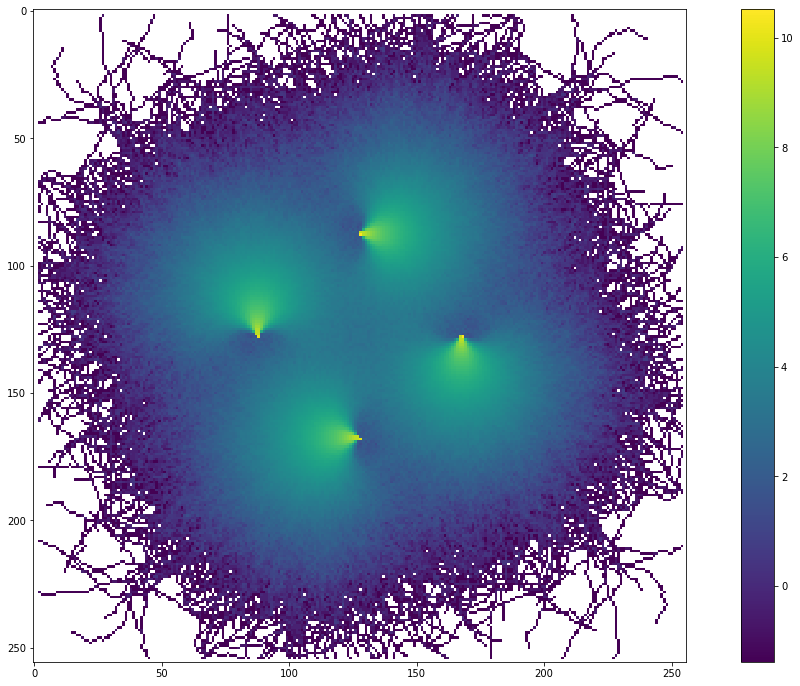

In [144]:
uset = np.array([[-40, 0, np.pi/2], [0, -40, 0], [40, 0, -np.pi/2], [0, 40, -np.pi]])

source_field = generate_field(uset, points)

plt.figure(figsize = (20, 12))
plt.imshow(np.log(np.sum(source_field, axis = 2)), interpolation='none')
plt.colorbar()
plt.show()

/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


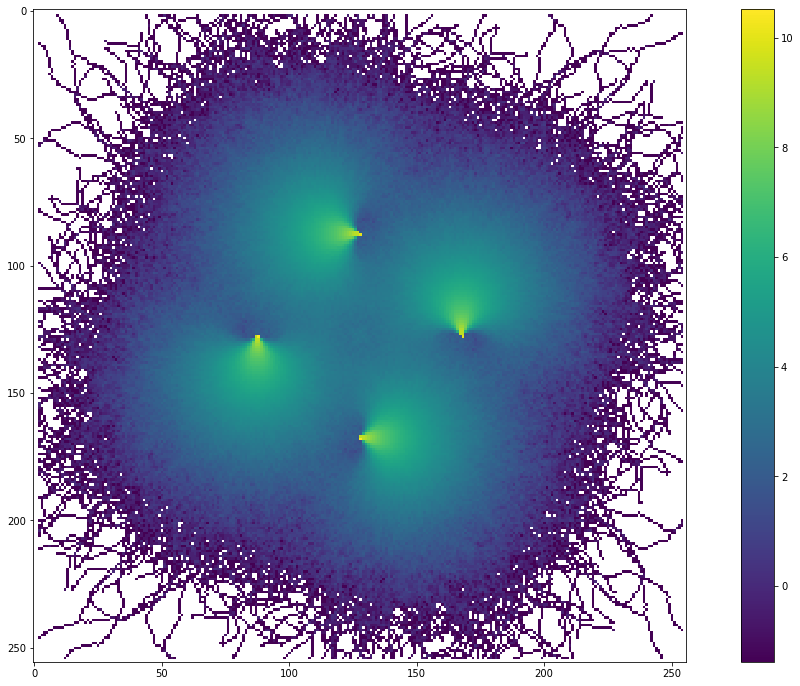

In [145]:
vset = np.array([[-40, 0, np.pi/2], [0, -40, 0], [40, 0, -np.pi/2], [0, 40, -np.pi]])

sink_field = generate_field(vset, points, isSinkField = True)

plt.figure(figsize = (20, 12))
plt.imshow(np.log(np.sum(sink_field, axis = 2)), interpolation='none')
plt.colorbar()
plt.show()

In [146]:
comp_field = np.multiply(source_field, sink_field)

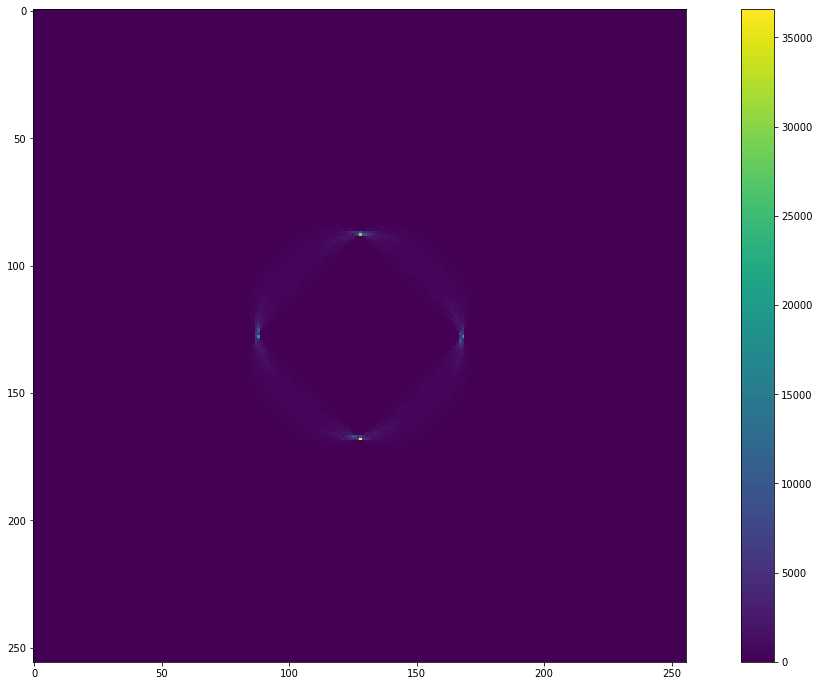

In [147]:
plt.figure(figsize = (20, 12))
plt.imshow(np.sum(comp_field, axis = 2), interpolation='none')
plt.colorbar()
plt.show()

/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals 

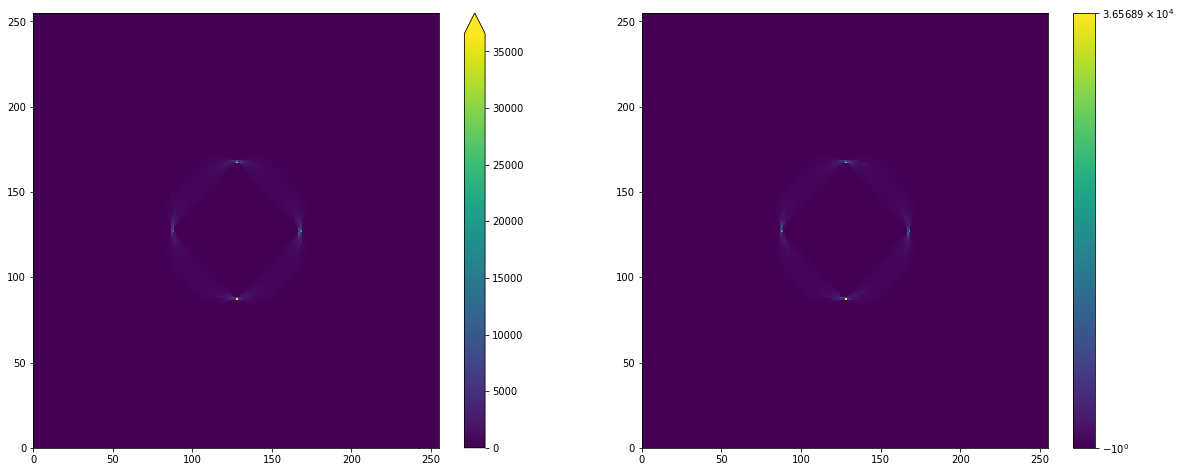

In [148]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook

comp_s_80_viz = np.sum(comp_field, axis = 2)

N = 100
Y, X = np.mgrid[0:256, 0:256]
Z = comp_s_80_viz[::-1,:]

fig, ax = plt.subplots(1, 2, figsize=(20,8))

pcm = ax[0].pcolormesh(X, Y, Z, cmap='viridis', vmin=0)
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolormesh(X, Y, Z,
                       norm=colors.SymLogNorm(linthresh=10**6.5, linscale=1,
                                              vmin=-1.0, vmax=Z.max()),
                       cmap='viridis')
fig.colorbar(pcm, ax=ax[1], extend='neither')

plt.show()

In [149]:
import skimage.io
import cv2

def visualize_pts(img, pts, hw=128):
  plt.figure(figsize=(20, 10))
  i = 0
  for pt in pts:
    x_val, y_val, angle = pt
    x_val += hw
    y_val += hw
    img[ int(y_val)-2 : int(y_val)+3, int(x_val)-2: int(x_val)+3 ] = 0
    # Draw a line that visualizes the angle going out of this point
    x_val_end, y_val_end = x_val, y_val
    
    print(pt)
    
    width = 40
    
    if angle == 0:
      x_val_end += 40
    elif angle == -np.pi:
      x_val_end -= 40
    elif angle == np.pi/2:
      y_val_end -= 40
    elif angle == -np.pi/2:
      y_val_end += 40
    elif 0 < angle < np.pi / 2:
      x_val_end += 40
      y_val_end -= 40 * np.tan(angle)
    elif np.pi/2 < angle < np.pi:
      x_val_end -= 40
      y_val_end -= 40 * np.tan(np.pi - angle)
    elif -np.pi/2 < angle < 0:
      print(pt)
      x_val_end += 40
      y_val_end += 40 * np.tan(np.abs(angle))
    elif -np.pi < angle < -np.pi/2:
      x_val_end -= 40
      y_val_end += 40 * np.tan(angle + np.pi)

    x_pts = [x_val, x_val_end]
    y_pts = [y_val, y_val_end]
    color = "red" if i < 4 else "blue"
#     plt.plot(x_pts, y_pts, marker = 'o', color=color)
    i += 1
    
  plt.imshow(img) 
  


In [150]:
triangle_img = np.array(skimage.io.imread(fname="./imgs/kanizas_triangle.png", as_gray=True))
triangle_img_vis = np.copy(triangle_img)

# Visualize the points on the image
uset = np.array([[-4*2, -9*2, -2 * np.pi / 3], [4*2, -9*2, -np.pi / 3], [-10*2, 16*2, 0]])
vset = np.array([[14*2, 9*2, - np.pi / 3], [-14*2, 9*2, -2 * np.pi / 3], [10*2, 16*2, 0]])

triangle_img -= 1
triangle_img *= -1


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


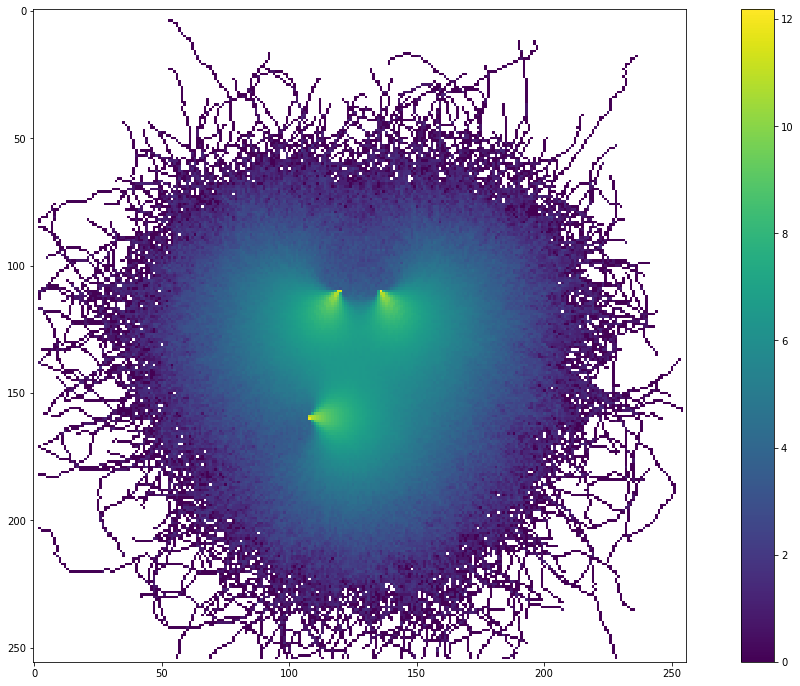

In [151]:
source_fields = generate_indiv_fields(uset, points, isSinkField = False)
source_field = np.zeros((256, 256, 36))
for field in source_fields:
  source_field += field
plt.figure(figsize = (20, 12))
plt.imshow(np.log(np.sum(source_field, axis = 2)), interpolation='none')
plt.colorbar()
plt.show()


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


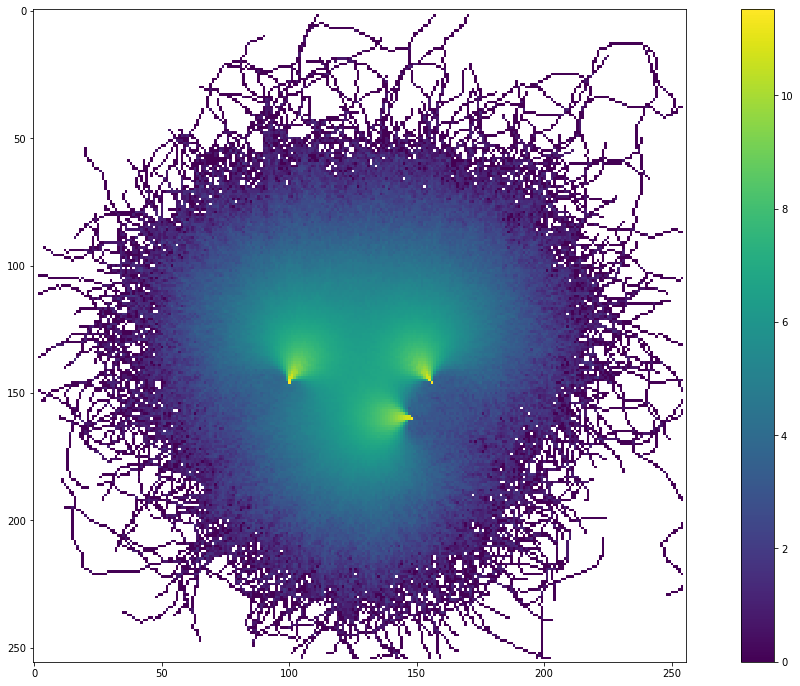

In [152]:
sink_fields = generate_indiv_fields(vset, points, isSinkField = True)
sink_field = np.zeros((256, 256, 36))
for field in sink_fields:
  sink_field += field
plt.figure(figsize = (20, 12))
plt.imshow(np.log(np.sum(sink_field, axis = 2)), interpolation='none')
plt.colorbar()
plt.show()


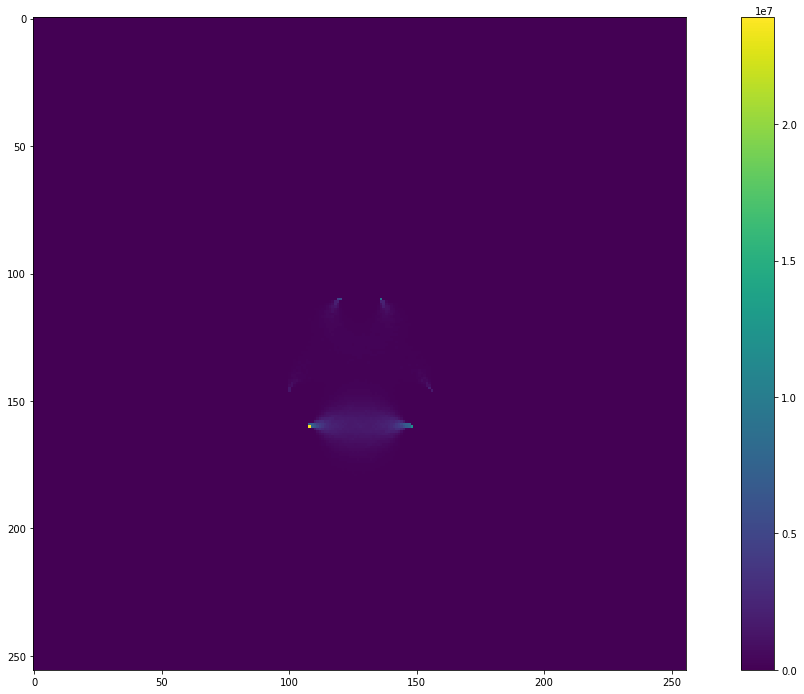

In [153]:
comp_field = np.zeros((256, 256))
for i in range(0, len(source_fields)):
  src = np.sum(source_fields[i], axis=2)
  sink = np.sum(sink_fields[i], axis=2)
  prod = np.multiply(src, sink)
  comp_field += prod
  
plt.figure(figsize = (20, 12))
plt.imshow(comp_field, interpolation='none')
plt.colorbar()
plt.show()

(128, 128)


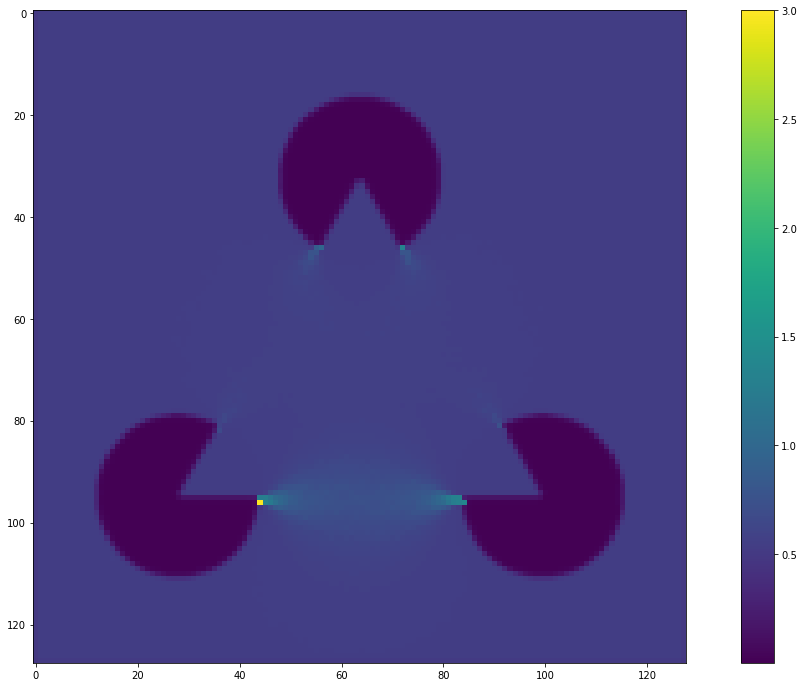

In [154]:
# Normalize the completion field image

from skimage.transform import rescale, resize, downscale_local_mean
tri_img = np.array(skimage.io.imread(fname="./imgs/kanizas_triangle.png", as_gray=True))
comp_field = comp_field[64:192, 64:192]
print(comp_field.shape)

# Pad the loaded paisleys img with black bars so that the shape is (256, 256)
tri_img = resize(tri_img, (tri_img.shape[0] // 2, tri_img.shape[1] // 2),
                       anti_aliasing=True)
comp_field /= np.max(comp_field)
final_overlay = tri_img + comp_field
final_overlay /= np.max(final_overlay)
final_overlay += comp_field * 2

plt.figure(figsize = (20, 12))
plt.imshow(final_overlay, interpolation='none')
plt.colorbar()
plt.show()


[35.        10.         0.5404195]
[48.         37.          0.78539816]
[-97.          22.           1.32581766]
[-81.          37.           1.16590454]
[ 81.         -29.           1.07144961]
[ 95.         -23.           1.10714872]
[-55.         -39.           0.78539816]
[-40.          -7.           0.55859932]


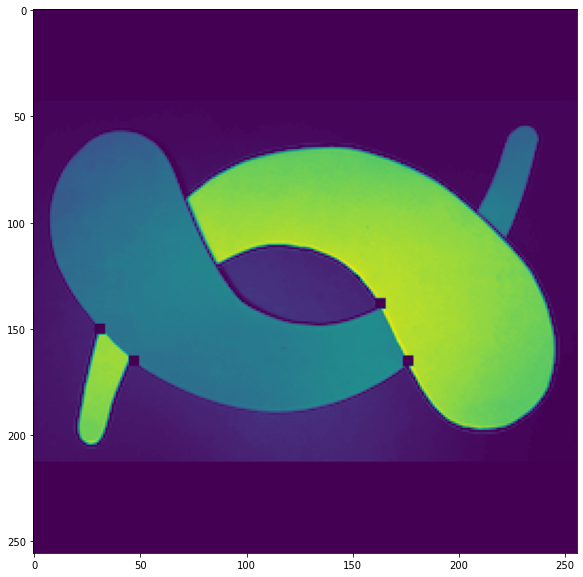

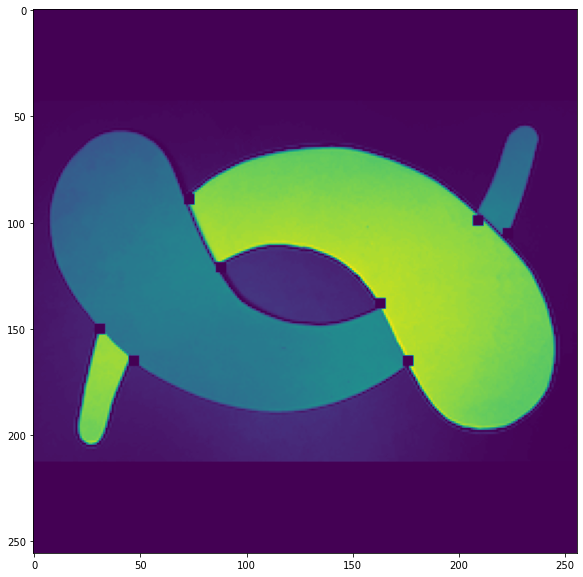

In [155]:
paisleys_loaded = np.array(skimage.io.imread(fname="./imgs/paisley.png", as_gray=True))

# Pad the loaded paisleys img with black bars so that the shape is (256, 256)
paisleys = np.zeros((256, 256))
paisleys[43:213, 0:256] = paisleys_loaded[:, :]

paisleys_vis = np.copy(paisleys)

# Visualize the points on the image
uset = np.array([
  [163-128, 181-128-43, np.arctan2(3, 5)], 
  [176-128, 208-128-43, np.pi / 4], 
  [31-128, 107-128+43, np.arctan2(8, 2)],
  [47-128, 122-128+43, np.arctan2(7, 3)]
])
vset = np.array([
  [209-128, 142-128-43, normalize_angle(-2 * np.pi + np.arctan2(5.5, 3))],
  [223-128, 148-128-43, normalize_angle(-2 * np.pi + np.arctan2(8, 4))],
  [73-128, 46-128+43, normalize_angle(-2 * np.pi + np.pi / 4)],
  [88-128, 78-128+43, normalize_angle(-2 * np.pi + np.arctan2(5, 8))]
])

visualize_pts(paisleys_vis, uset)
visualize_pts(paisleys_vis, vset)


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


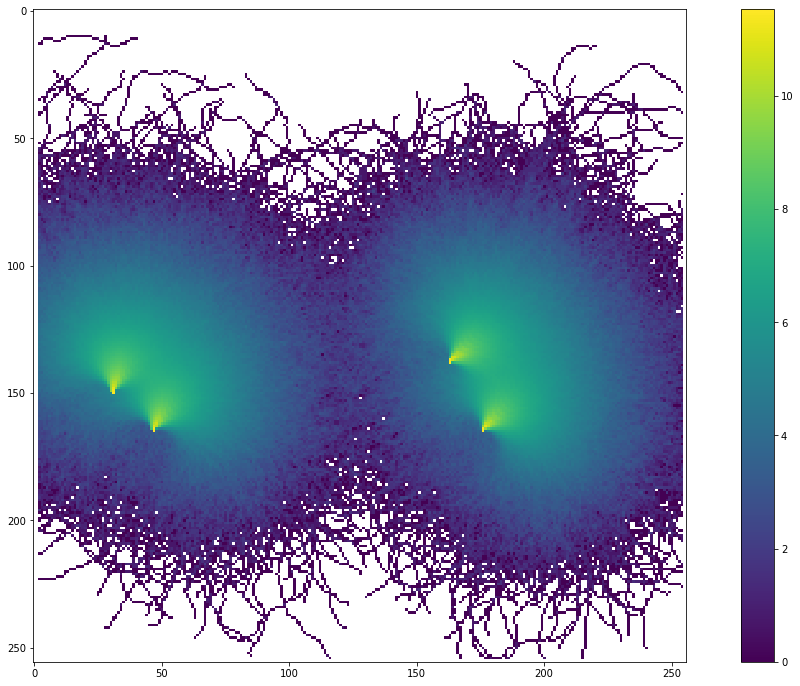

In [156]:
source_fields = generate_indiv_fields(uset, points, isSinkField = False)
source_field = np.zeros((256, 256, 36))
for field in source_fields:
  source_field += field
plt.figure(figsize = (20, 12))
plt.imshow(np.log(np.sum(source_field, axis = 2)), interpolation='none')
plt.colorbar()
plt.show()


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/sidgupta/Desktop/CSC420/Stochastic_Completion_Fields/scf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


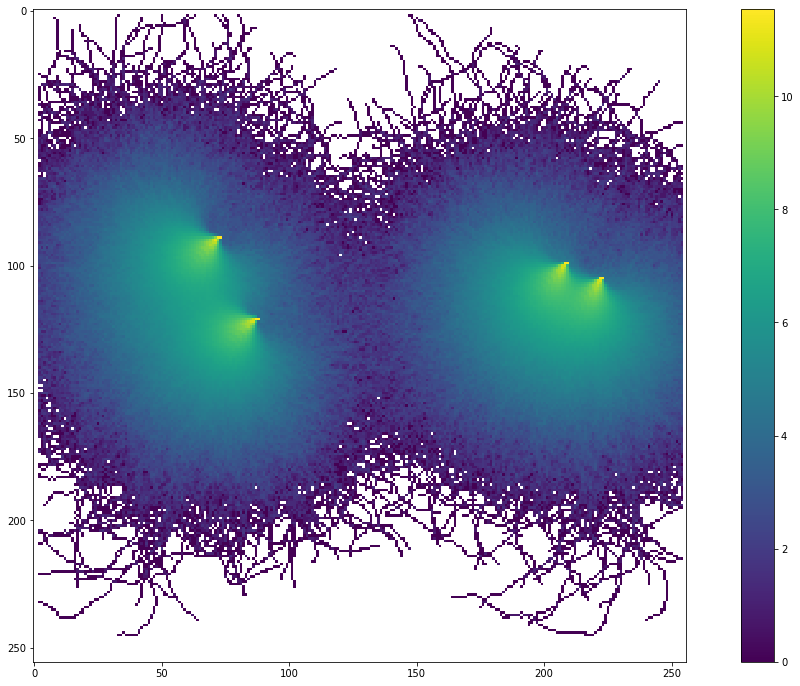

In [157]:
sink_fields = generate_indiv_fields(vset, points, isSinkField = True)
sink_field = np.zeros((256, 256, 36))
for field in sink_fields:
  sink_field += field
plt.figure(figsize = (20, 12))
plt.imshow(np.log(np.sum(sink_field, axis = 2)), interpolation='none')
plt.colorbar()
plt.show()


(256, 256)
(256, 256)
(256, 256)
(256, 256)


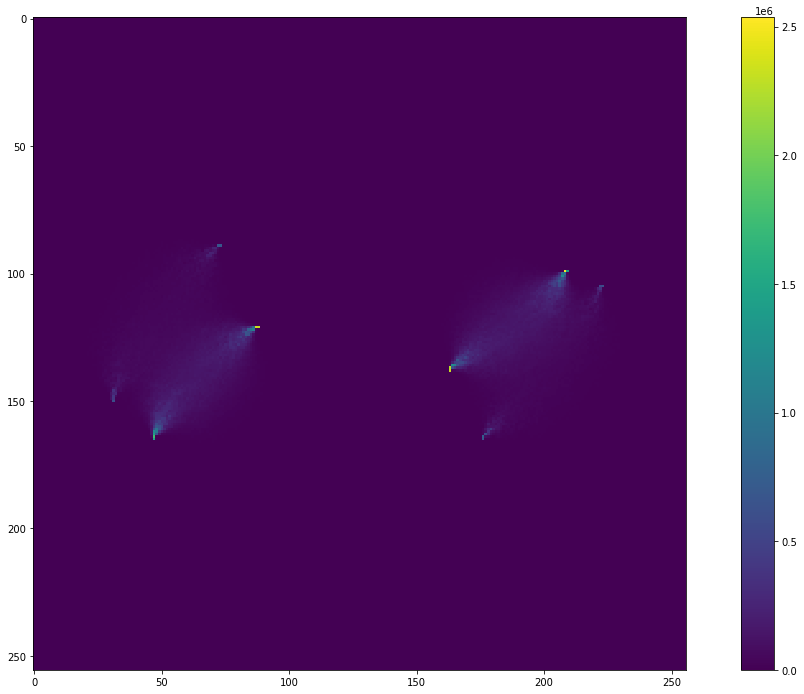

In [158]:
comp_field = np.zeros((256, 256))
for i in range(0, len(source_fields)):
  src = np.sum(source_fields[i], axis=2)
  sink = np.sum(sink_fields[i], axis=2)
  prod = np.multiply(src, sink)
  print(prod.shape)
  comp_field += prod
  
plt.figure(figsize = (20, 12))
plt.imshow(comp_field, interpolation='none')
plt.colorbar()
plt.show()

(256, 256)


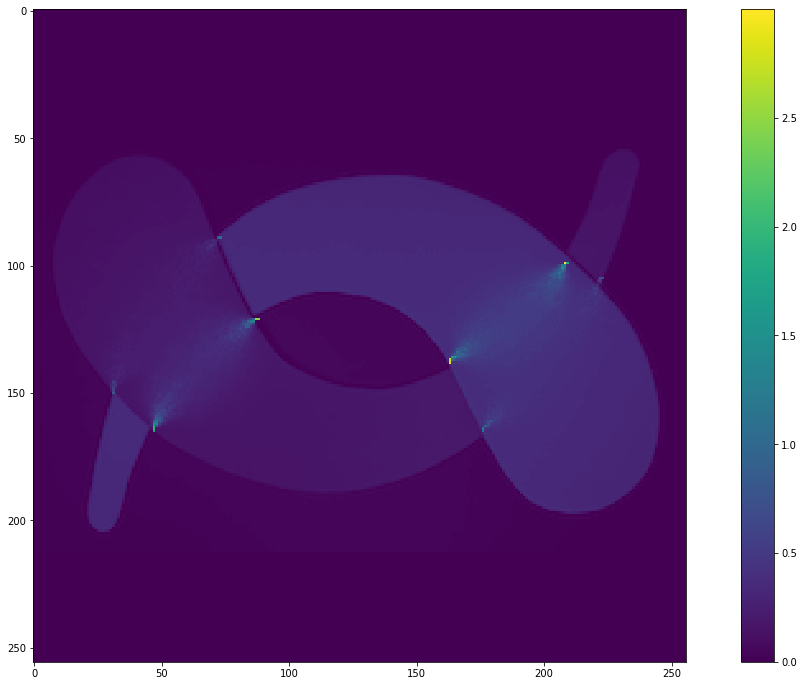

In [159]:
print(paisleys.shape)
comp_field /= np.max(comp_field)
final_overlay = paisleys + comp_field
final_overlay /= np.max(final_overlay)
final_overlay += comp_field * 2

plt.figure(figsize = (20, 12))
plt.imshow(final_overlay, interpolation='none')
plt.colorbar()
plt.show()